# `014` Attention mechanisms (and dropout)

Requirements: 010 Embeddings, 013 LSTM

⚠️ WIP

There is a fundamental problem with LSTM, GRU and other RNNs, which is that they are not feedforward, so that the individual timesteps of processing a sequence cannot be parallelized. This time dependency makes training slower. RNNs typically capture dependencies 100

There is a different kind of layer called `Attention` that can be used to solve this problem. The idea is to have a layer that can look at the entire sequence at once and decide which parts of the sequence are important for the current timestep. This way, the layer can be parallelized and can capture long-term dependencies. The underlying idea is converting every element in the sequence into a linear combination of all the elements in the sequence, with the weights of the linear combination being learned. Let's see an implementation in code:

In [1]:
from json import loads
from matplotlib import pyplot as plt
from string import ascii_letters, digits
from time import time
from unicodedata import category, normalize
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocabulary = ascii_letters + digits + ' .,;\'!'
c2i = {c: i for i, c in enumerate(vocabulary)}
i2c = {i: c for i, c in enumerate(vocabulary)}

def vectorize_sentence(s):
	return [c2i[c] for c in normalize('NFD', s) if category(c) != 'Mn' and c in vocabulary]

In [2]:
input = torch.tensor([vectorize_sentence('Hello, World!')])  # (batch_size=1, context_length=13)

embedding_channels = 8
embeddings = torch.randn(len(vocabulary), embedding_channels)  # (vocabulary_size, embedding_channels=8)
input = embeddings[input]  # (batch_size=1, context_length=13, embedding_channels=8)

head_size = 16
# key space mapping: what each has to offer
W_k = torch.randn(embedding_channels, head_size)  # (embedding_channels=8, head_size=16)
# query space mapping: what each token is looking for
W_q = torch.randn(embedding_channels, head_size)  # (embedding_channels=8, head_size=16)

k = input @ W_k  # (batch_size=1, context_length=13, head_size=16)
q = input @ W_q  # (batch_size=1, context_length=13, head_size=16)

# dot product of what each token is looking for and what each has to offer -> attention weights: how much each token should pay attention to each other token
# note that you swap the last two dimensions of k to make a square matrix of dot products
attention_weights = q @ k.transpose(-2, -1)  # (batch_size=1, context_length=13, context_length=13)
# now, divide it by the square root of the head size to make the dot products more stable
attention_weights /= head_size ** 0.5
# apply a softmax to make the attention weights sum to 1
attention_weights = attention_weights.softmax(dim=-1)  # (batch_size=1, context_length=13, context_length=13)

# value space: what each token is contributing
W_v = torch.randn(embedding_channels, head_size)  # (embedding_channels=8, head_size=16)

v = input @ W_v  # (batch_size=1, context_length=13, head_size=16)

# weighted sum of what each token is contributing, based on how much each token should pay attention to each other token
output = attention_weights @ v  # (batch_size=1, context_length=13, head_size=16)

In [3]:
with open('custom-data/sentences.json', encoding='utf-8') as f:
	data = loads(f.read())

languages = list(data.keys())

X, Y = [], []
block_size = 32
for language, sentences in data.items():
	for sentence in sentences:
		sentence = vectorize_sentence(sentence)
		for i in range(len(sentence) - block_size + 1):
			X.append(sentence[i:i+block_size])
			Y.append(languages.index(language))
ix = torch.randperm(len(X))
X = torch.tensor([X[i] for i in ix], device=device)
Y = torch.tensor([Y[i] for i in ix], device=device)

print(f'Loaded {len(X)} sentences from {len(languages)} languages using {len(vocabulary)} different characters')
print(X[0], Y[0], '->', ''.join(i2c[i.item()] for i in X[0]), languages[Y[0]])

Loaded 6232944 sentences from 8 languages using 68 different characters
tensor([ 4,  8, 18, 19,  0, 19,  8, 14, 13, 62,  8, 13, 62, 38,  4,  8, 25,  7,
        14, 20, 62, 20,  1,  4, 17, 22,  0, 11, 19,  8,  6, 19]) tensor(1) -> eistation in Meizhou uberwaltigt de


In [4]:
class SimpleAttention(torch.nn.Module):
	def __init__(self, embedding_channels, head_size):
		super().__init__()
		self.W_k = torch.nn.Linear(embedding_channels, head_size, bias=False)
		self.W_q = torch.nn.Linear(embedding_channels, head_size, bias=False)
		self.W_v = torch.nn.Linear(embedding_channels, head_size, bias=False)
	def forward(self, x):
		k = self.W_k(x)
		q = self.W_q(x)
		attention = q @ k.transpose(-2, -1) / k.size(-1) ** 0.5
		attention = attention.softmax(dim=-1)
		v = self.W_v(x)
		return attention @ v

class MultiHeadAttention(torch.nn.Module):
	def __init__(self, embedding_channels, num_heads, head_size):
		super().__init__()
		self.heads = torch.nn.ModuleList([
			SimpleAttention(embedding_channels, head_size)
			for _ in range(num_heads)
		])
		self.fc = torch.nn.Linear(embedding_channels, num_heads * head_size)
	def forward(self, x):
		x = torch.cat([head(x) for head in self.heads], dim=-1)
		return self.fc(x)
	
class LanguageClassifier(torch.nn.Module):
	def __init__(self, vocabulary_size, output_classes, block_size=32, embedding_channels=128, num_heads=4, head_size=32):
		super().__init__()
		self.character_embedding = torch.nn.Embedding(vocabulary_size, embedding_channels)
		self.positional_embedding = torch.nn.Embedding(block_size, embedding_channels)
		self.lstm = torch.nn.LSTM(embedding_channels, embedding_channels, batch_first=True)
		self.dropout1 = torch.nn.Dropout(.2)
		self.attention = MultiHeadAttention(embedding_channels, num_heads, head_size)
		self.dropout2 = torch.nn.Dropout(.2)
		self.fc = torch.nn.Linear(embedding_channels, output_classes)
	
	def forward(self, x):
		ch_emb = self.character_embedding(x)
		pos_emb = self.positional_embedding(torch.arange(x.size(-1), device=x.device))
		x = ch_emb + pos_emb
		x = self.attention(x)
		x = self.dropout1(x)
		x = self.lstm(x)[0]
		x = self.dropout2(x)
		return self.fc(x[:, -1])

model = LanguageClassifier(len(vocabulary), len(languages)).to(device)
print(f'Created model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters')

Created model with 211,592 parameters


In [5]:
def train(model, iterations=10000, batch_size=32, lr=3e-3):
	start = time()
	criterion = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	losses = []
	for i in range(iterations):
		ix = torch.randint(len(X), (batch_size,))
		xb, yb = X[ix], Y[ix]
		loss = criterion(model(xb), yb)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		losses.append(loss.item())
		if i % 1000 == 0 and i > 0 or i == 50:
			remaining = (time() - start) * (iterations - i) / (i + 1)
			print(f'Epoch {i:4} loss: {loss.item():.4f} remaining: {remaining//60:.0f}:{remaining%60:02.0f}')
	return losses

print('Training with default learning rate')
losses = train(model)
print('Training with lower learning rate')
losses.extend(train(model, lr=3e-4))

Training with default learning rate


Epoch   50 loss: 1.6908 remaining: 9:45
Epoch 1000 loss: 1.6480 remaining: 3:56
Epoch 2000 loss: 1.6244 remaining: 3:15
Epoch 3000 loss: 1.7769 remaining: 3:16
Epoch 4000 loss: 1.6279 remaining: 2:41
Epoch 5000 loss: 1.6463 remaining: 2:14
Epoch 6000 loss: 1.5292 remaining: 1:46
Epoch 7000 loss: 1.5104 remaining: 1:21
Epoch 8000 loss: 1.6421 remaining: 0:53
Epoch 9000 loss: 1.6216 remaining: 0:27
Training with lower learning rate
Epoch   50 loss: 1.8128 remaining: 3:19
Epoch 1000 loss: 1.7077 remaining: 3:26
Epoch 2000 loss: 1.6257 remaining: 3:19
Epoch 3000 loss: 1.5955 remaining: 2:58
Epoch 4000 loss: 1.7342 remaining: 2:42
Epoch 5000 loss: 1.7832 remaining: 2:09
Epoch 6000 loss: 1.8027 remaining: 1:46
Epoch 7000 loss: 1.6263 remaining: 1:19
Epoch 8000 loss: 1.4891 remaining: 0:54
Epoch 9000 loss: 1.8763 remaining: 0:27


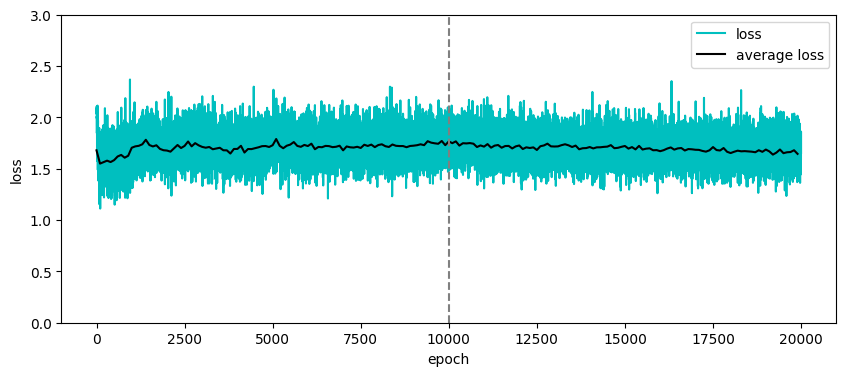

In [6]:
average_losses = torch.tensor(losses).view(-1, 100).mean(1)
plt.figure(figsize=(10, 4))
plt.plot(losses, c='c', label='loss')
plt.plot(range(0, len(losses), 100), average_losses, c='k', label='average loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 3)
plt.axvline(10000, c='gray', linestyle='--');

Accuracy: 0.28%


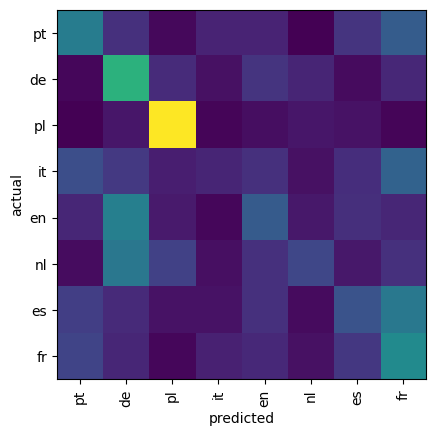

In [7]:
ix = torch.randint(len(X), (1000,))
X_test, Y_test = X[ix], Y[ix]

confusion_matrix = torch.zeros(len(languages), len(languages), device=device)
output = model(X_test).argmax(1)
for true_label, predicted_label in zip(Y_test, output):
	confusion_matrix[true_label, predicted_label] += 1
confusion_matrix /= confusion_matrix.sum(1, keepdim=True)

plt.imshow(confusion_matrix.cpu().numpy())
plt.xticks(range(len(languages)), languages, rotation=90)
plt.yticks(range(len(languages)), languages)
plt.xlabel('predicted')
plt.ylabel('actual')

accuracy = confusion_matrix.diag().sum().item() / len(Y_test)
print(f'Accuracy: {100 * accuracy:.2f}%')